In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from PIL import Image
from quickdraw import QuickDrawDataGroup
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import tf2onnx
import onnx
import onnxruntime as ort

In [4]:
# Определяем размеры изображений
image_size = (128, 128)
max_drawings = 5000
# Функция для генерации изображений класса
def generate_class_images(name, recognized):
    directory = "dataset/" + name

    if not os.path.exists(directory):
        os.makedirs(directory)

    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = os.path.join(directory, f"{img.key_id}.png")
        img.get_image(stroke_width=3).resize(image_size).save(filename)

# Список классов для загрузки
classes = ['birthday cake','clock', 'cactus', 'flamingo', 'tornado', 'train', 'octopus','lighthouse', 'mountain','palm tree','sailboat','wine glass','pencil', 'butterfly']
# Генерация изображений для указанных классов
for class_name in classes:
    generate_class_images(class_name, recognized=True)

# Функция для загрузки изображений и меток
def load_images(classes):
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = "dataset/" + class_name
        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = Image.open(img_path).convert('L')  # Конвертация в градации серого
            img = img.resize(image_size)  # Изменение размера
            images.append(np.array(img))
            labels.append(label)
    return np.array(images), np.array(labels)

# Загрузка изображений
images, labels = load_images(classes)

# Предобработка изображений
images = images.reshape(-1, 128, 128, 1).astype('float32') / 255.0  # Нормализация
labels = np.eye(len(classes))[labels]  # One-hot encoding

# Разделение данных на обучающую, валидационную и тестовую выборки
# Сначала разделяем данные на обучающую (80%) и временную выборку (20%)
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.2, random_state=53)

# Затем делим временную выборку на валидационную (70% от 20%) и тестовую (30% от 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=53)

Визуализация для выбораклассов

In [ ]:
image_size = (128, 128)
def generate_class_images(name, recognized):
    directory = "dataset/" + name

    if not os.path.exists(directory):
        os.makedirs(directory)

    images = QuickDrawDataGroup(name, max_drawings=4, recognized=recognized)
    for img in images.drawings:
        filename = os.path.join(directory, f"{img.key_id}.png")
        img.get_image(stroke_width=3).resize(image_size).save(filename)

# Список классов для загрузки
classes = ['butterfly','cat']

# Загрузка изображений для каждого класса
for class_name in classes:
    generate_class_images(class_name, recognized=True)


# Функция для загрузки изображений из указанного класса
def load_class_images(class_name, num_images=3):
    class_dir = f"dataset/{class_name}"
    image_files = os.listdir(class_dir)
    images = []

    for img_file in image_files:
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path).convert('L')  # Конвертация в градации серого
        img = img.resize(image_size)  # Изменение размера
        images.append(np.array(img))

    return images

# Загрузка изображений для классов 'hurricane' и 'tornado'
# train_images = load_class_images('train')
# horse_images = load_class_images('horse')
# house_plant_images = load_class_images('house plant')
for k in classes:
  load_class_images(k)
def visualize_images(classes):
    fig, axes = plt.subplots(len(classes), 4, figsize=(10, 6))

    for i, class_name in enumerate(classes):
        images = load_class_images(class_name)
        for ax, img in zip(axes[i], images):
            ax.imshow(img, cmap='gray')
            ax.axis('off')  # Скрыть оси
            ax.set_title(class_name)

    plt.tight_layout()
    plt.show()


visualize_images(classes)

Архитектура сверточной сети

In [7]:
n_classes = len(classes)
input_shape = (128, 128, 1)
dropout_rate = 0.2
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1. / 255, input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),

    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),

    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(dropout_rate),

    tf.keras.layers.Dense(n_classes, activation="softmax")
])

Были попытки использовать свою лосс-функцию, но результаты с ней хуже

In [7]:
# Определяем функцию потерь с Elastic Net
#@tf.keras.saving.register_keras_serializable()
def elastic_net_loss(y_true, y_pred, alpha=0.1, l1_ratio=0.5):
    # Кросс-энтропийная потеря
    cross_entropy_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # L1 и L2 потери
    l1_loss = tf.reduce_mean(tf.abs(y_pred))
    l2_loss = tf.reduce_mean(tf.square(y_pred))
    # Общая потеря
    return cross_entropy_loss + alpha * (l1_ratio * l1_loss + (1 - l1_ratio) * l2_loss)

Были пробы найти лучшие параметры для модели, в итоге была выбрана верхняя, как лучшая

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

n_classes = len(classes)
input_shape = (128, 128, 1)

def create_model1(optimizer='adam', dropout_rate=0.2):
    model1 = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1. / 255, input_shape=(128, 128, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(n_classes, activation="softmax")
    ])
    model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model1

def create_model2(optimizer='adam', dropout_rate=0.2):
    model1 = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1. / 255, input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
        tf.keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(800, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(384, activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(n_classes, activation="softmax")
    ])
    # model2.compile(optimizer=optimizer, loss='elastic_net_loss', metrics=['AUC'])
    model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model2

# Обертывание модели в KerasClassifier
model1 = KerasClassifier(model=create_model1(dropout_rate=0.1), verbose=0)
model2 = KerasClassifier(model=create_model2(dropout_rate=0.1), verbose=0)
model3 = KerasClassifier(model=create_model1(dropout_rate=0.2), verbose=0)
model4 = KerasClassifier(model=create_model2(dropout_rate=0.2), verbose=0)
model5 = KerasClassifier(model=create_model1(dropout_rate=0.3), verbose=0)
model6 = KerasClassifier(model=create_model2(dropout_rate=0.3), verbose=0)
# Определение параметров для GridSearchCV
param_grid = {
    'epochs': [6]
}
X_train2k, y_train2k = X_train[0:2000], y_train[0:2000]

models = [model1, model2, model3, model4, model5, model6]

# Выполнение GridSearchCV для каждой модели
best_models = []
for model in models:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)
    grid_result = grid.fit(X_train2k, y_train2k)
    best_models.append(grid_result)

# Вывод лучших результатов
for i, result in enumerate(best_models):
    print(f"Model {i+1} Best: {result.best_score_} using {result.best_params_}")
    
# # Настройка GridSearchCV для первой модели
# grid1 = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result1 = grid1.fit(X_train2k, y_train2k)

# # Настройка GridSearchCV для второй модели
# grid2 = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result2 = grid2.fit(X_train2k, y_train2k)

# # Вывод результатов для первой модели
# print(f"Лучшие параметры для модели 1: {grid_result1.best_params_}")
# print(f"Лучший результат для модели 1: {grid_result1.best_score_}")

# # Вывод результатов для второй модели
# print(f"Лучшие параметры для модели 2: {grid_result2.best_params_}")
# print(f"Лучший результат для модели 2: {grid_result2.best_score_}")
# # Вывод результатов
# print(f"Лучшие параметры: {grid_result.best_params_}")
# print(f"Лучший результат: {grid_result.best_score_}")

Смешанная точность устанавливалась для оптимизации памяти, лучше без нее

In [9]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision

# Установка политики смешанной точности
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

opt = tf.keras.optimizers.Adam()

opt = mixed_precision.LossScaleOptimizer(opt, loss_scale='dynamic')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)


In [17]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(56000, 128, 128, 1) (56000, 14)
(9800, 128, 128, 1) (9800, 14)


In [19]:
#model = tf.keras.models.load_model('best_model.keras')
y_train = np.argmax(y_train, axis=1)  # Now shape will be (56000,)
y_val = np.argmax(y_val, axis=1)      # Now shape will be (9800,)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Настройка колбеков
current_epoch = ModelCheckpoint('current_model_epoch_{epoch:02d}.keras', save_weights_only=False, verbose=1)
best_epoch = ModelCheckpoint('best_model_epoch_{epoch:02d}.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='accuracy', patience=3, min_delta=0.01, mode='max', verbose=1) #'val_auc'

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=15, batch_size=8,
                    callbacks=[best_epoch, early_stopping, current_epoch])

Epoch 1/15
6999/7000 [============================>.] - ETA: 0s - loss: 0.9273 - accuracy: 0.7130
Epoch 1: accuracy improved from -inf to 0.71300, saving model to best_model_epoch_01.keras

Epoch 1: saving model to current_model_epoch_01.keras
7000/7000 [==============================] - 81s 9ms/step - loss: 0.9272 - accuracy: 0.7130 - val_loss: 5436.8916 - val_accuracy: 0.1069
Epoch 2/15
6999/7000 [============================>.] - ETA: 0s - loss: 0.6594 - accuracy: 0.7954
Epoch 2: accuracy improved from 0.71300 to 0.79541, saving model to best_model_epoch_02.keras

Epoch 2: saving model to current_model_epoch_02.keras
7000/7000 [==============================] - 63s 9ms/step - loss: 0.6593 - accuracy: 0.7954 - val_loss: 433.0755 - val_accuracy: 0.1239
Epoch 3/15
6999/7000 [============================>.] - ETA: 0s - loss: 0.5982 - accuracy: 0.8147
Epoch 3: accuracy improved from 0.79541 to 0.81473, saving model to best_model_epoch_03.keras

Epoch 3: saving model to current_model_epoc

In [15]:
model.save('best_model.keras')

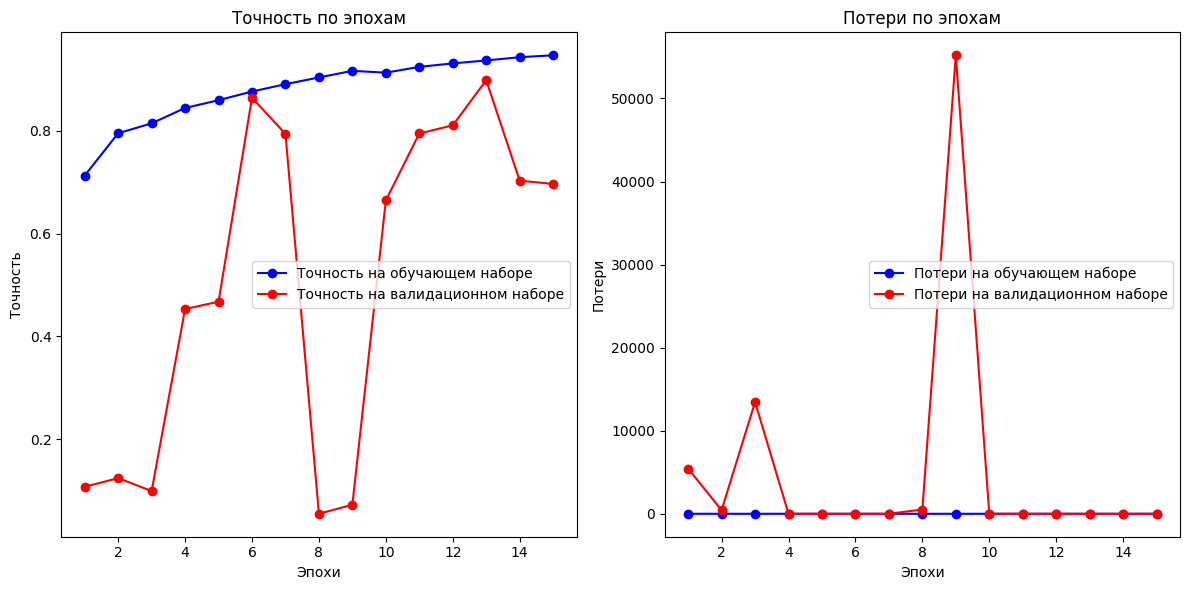

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Построение графика точности
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Точность на обучающем наборе')
plt.plot(epochs, val_accuracy, 'ro-', label='Точность на валидационном наборе')
plt.title('Точность по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

# Построение графика потерь
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Потери на обучающем наборе')
plt.plot(epochs, val_loss, 'ro-', label='Потери на валидационном наборе')
plt.title('Потери по эпохам')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.tight_layout()
plt.show()

Лучшая эпоха это 6,
можно проверить 13 эпоху.
Проверка на валидационном наборе

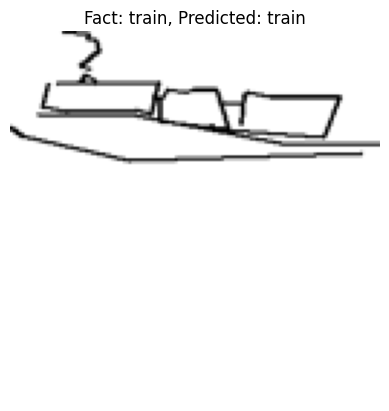

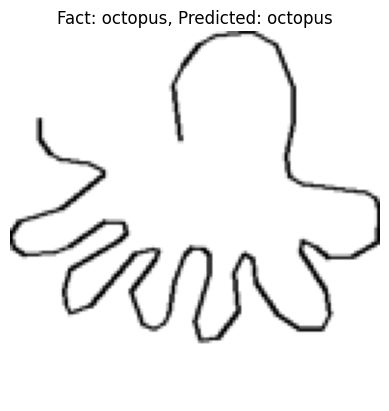

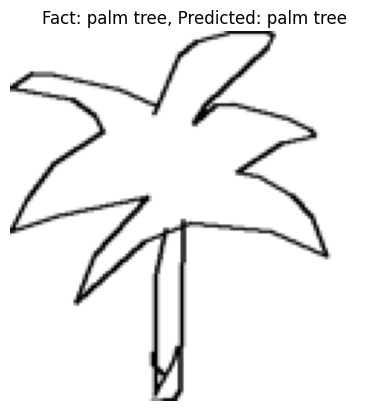

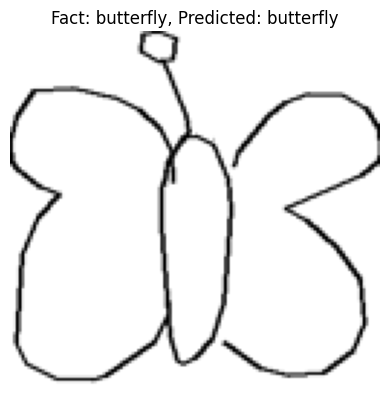

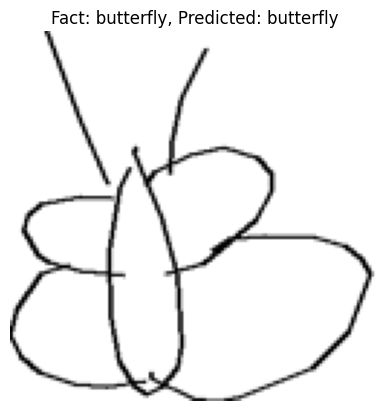

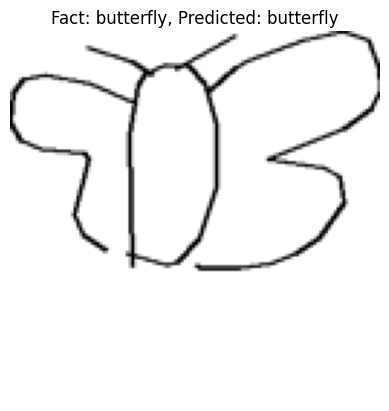

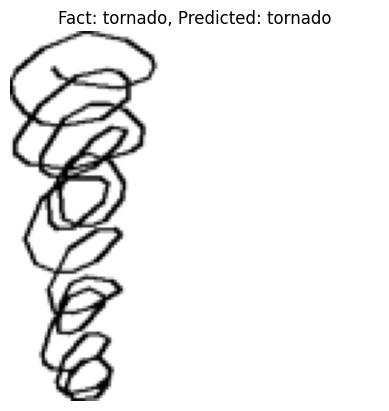

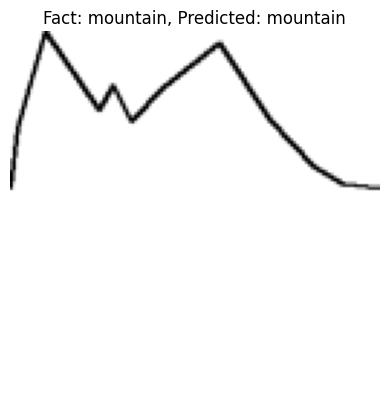

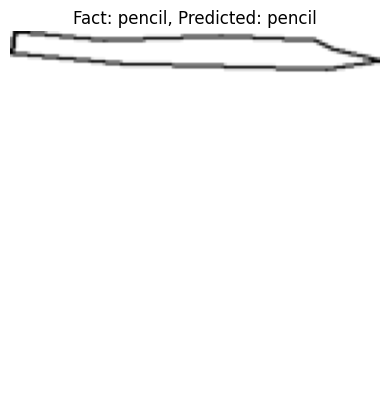

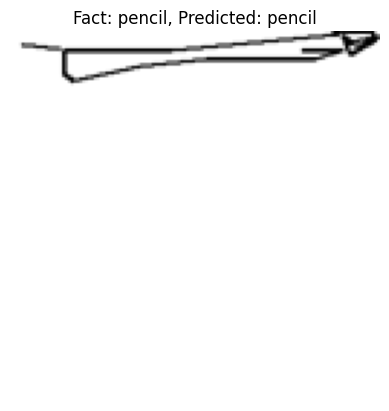

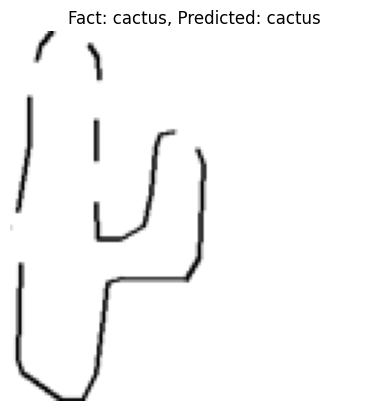

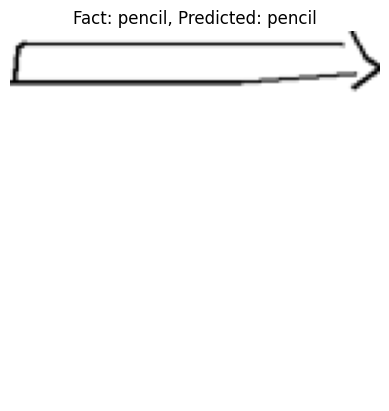

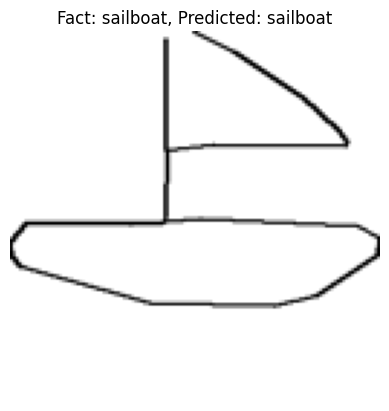

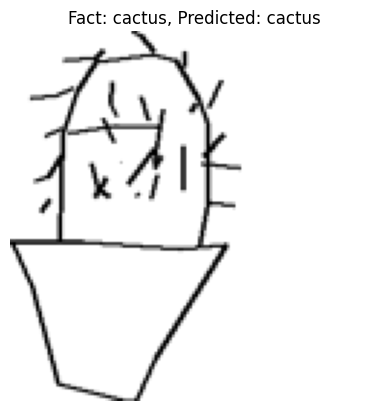

In [34]:
model = tf.keras.models.load_model('best_model_epoch_13.keras')
# Визуализация
def visualize_prediction(image, true_label, predicted_label):
    plt.imshow(image.reshape(128, 128), cmap='gray')
    plt.title(f'Fact: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Пример визуализации
for i in range(len(classes)):  # Визуализируем 10 примеров
    idx = np.random.randint(0, len(X_val))
    visualize_prediction(X_val[idx], classes[np.argmax(y_val[idx])], classes[np.argmax(model.predict(X_val[idx].reshape(1, 128, 128, 1)))])

# Функция для предсказания класса
def predict_class(image):
    image = image.reshape(1, 128, 128, 1)  # Изменение формы для модели
    prediction = model.predict(image)
    return classes[np.argmax(prediction)]

Ниже несколько вариантов загрузки модели, разные форматы. Происходила проверка на тестовых данных

In [10]:
# Загрузка модели
import tf2onnx
import tensorflow as tf
model = tf.keras.models.load_model('best_model_epoch_13.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.output_names=['output']
model.evaluate(X_test, y_test)
# Конвертация модели в ONNX
onnx_file_path = "detect_image_model.onnx"
onnx_model, _ = tf2onnx.convert.from_keras(model, opset=9, output_path=onnx_file_path)

print(f"Модель сохранена в формате ONNX: {onnx_file_path}")

132/132 [==============================] - 52s 5ms/step - loss: 0.5390 - accuracy: 0.9019
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Модель сохранена в формате ONNX: detect_image_model.onnx


In [ ]:
С помощью команды ниже вывод всех сохраненных слоев, можно увидеть какой слой не поддерживается

!python -m tf2onnx.convert --saved-model "./drawed_image_detect/saved_model" --output "./drawed_image_detect/detect_image_model.onnx" --opset 9 --verbose

In [19]:
model = tf.keras.models.load_model("./drawed_image_detect/best_model_epoch_13.keras")

saved_model_dir = "./drawed_image_detect/saved_model"
model.save(saved_model_dir, save_format="tf")

print(f"Модель сохранена как SavedModel в папке: {saved_model_dir}")

INFO:tensorflow:Assets written to: C:/Users/denis_zvd0gqp/drawed_image_detect/saved_model\assets
Модель сохранена как SavedModel в папке: C:/Users/denis_zvd0gqp/drawed_image_detect/saved_model


In [1]:
import tensorflow as tf
import tf2onnx

# Загружаем модель TensorFlow
model = tf.keras.models.load_model("./drawed_image_detect/best_model_epoch_13.keras")

spec = (tf.TensorSpec((None, 128, 128, 1), tf.float32),)

# Экспорт в ONNX с opset 9
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=9, output_path="./drawed_image_detect/9/detect_image_model.onnx")

print("Модель успешно экспортирована в формате ONNX с opset 9.")


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
Модель успешно экспортирована в формате ONNX с opset 9.


In [ ]:
model.summary()

In [ ]:
model_output_names = [output.name for output in model.outputs]
print("Output names:", model_output_names)

Output names: ['keras_tensor_647']


Предсказания, которые определяются на основе формата модели onnx

In [12]:
# Загрузка модели
import onnxruntime as ort
onnx_model = onnx.load("./15/detect_image_model.onnx")
ort_session = ort.InferenceSession("./15/detect_image_model.onnx")
n_tests = 15
# Функция для визуализации предсказаний
def visualize_prediction(image, true_label, predicted_label):
    plt.imshow(image.reshape(128, 128), cmap='gray')
    plt.title(f'Fact: {true_label}, Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()

# Функция для проверки и визуализации изображений из X_test
def check_and_visualize(X_test, y_test):
    for i in range(n_tests):  # Визуализируем 10 примеров
        idx = np.random.randint(0, len(X_test))
        image = X_test[idx]
        true_label = classes[np.argmax(y_test[idx])]
        predicted_label = predict_class(image)
        visualize_prediction(image, true_label, predicted_label)

# Функция для предсказания класса
def predict_class(image):
    image = image.reshape(1, 128, 128, 1)  # Изменение формы для модели
    input_name = ort_session.get_inputs()[0].name
    prediction = ort_session.run(None, {input_name: image.astype(np.float32)})[0]
    return classes[np.argmax(prediction)]

# Функция для преобразования изображения
def preprocess_image(img_path):
    image = Image.open(img_path).convert('L')  # Конвертация в градации серого
    image = image.resize((128, 128))  # Изменение размера до 128x128
    image_array = np.array(image) / 255.0  # Нормализация
    return image_array.reshape(1, 128, 128, 1)  # Изменение формы для модели

# Пример использования
check_and_visualize(X_test, y_test)

In [ ]:
# Для тестирования своего изображения
img_path = 'cake_test.png'
processed_image = preprocess_image(img_path)
predicted_class = predict_class(processed_image)
visualize_prediction(processed_image,'birthday cake', predicted_class)

img_path = 'flamingo_test.png'
processed_image = preprocess_image(img_path)
predicted_class = predict_class(processed_image)
visualize_prediction(processed_image,'flamingo', predicted_class)